
### **Project: Employee Turnover Prediction**

-----

#### **1. Introduction**




#  Employee Turnover Prediction

##  Problem Scenario

Portobello Tech, an app innovator, wants to predict employee turnover. They have collected data on employees' work details, including satisfaction levels, performance evaluations, project counts, working hours, tenure, promotions, and salary. The Human Resources (HR) department will use this data to identify patterns and predict which valuable employees are at risk of leaving.

As the Machine Learning Developer, the task is to build a model that can predict employee turnover and provide insights for retention strategies.


-----

#### **2. Setup and Data Loading**

Import the necessary libraries and load the dataset. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load the dataset
df = pd.read_csv('HR_comma_sep.csv')

# Display the first few rows of the dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


-----

#### **3. Data Quality Check**

Next, we'll perform some initial data quality checks. 


### 3.1. Checking for Missing Values and Duplicates

We'll start by checking for any missing values in the dataset and see if there are any duplicate rows.


In [3]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Drop duplicate rows
df.drop_duplicates(inplace=True)
print(f"\nShape of the dataframe after dropping duplicates: {df.shape}")

Missing values in each column:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

Number of duplicate rows: 3008

Shape of the dataframe after dropping duplicates: (11991, 10)


-----

#### **4. Exploratory Data Analysis (EDA)**

Now, let's dive into the data to understand the factors that contribute most to employee turnover.


### 4.1. Correlation Matrix

A correlation matrix will help us understand the linear relationships between the numerical features in our dataset.


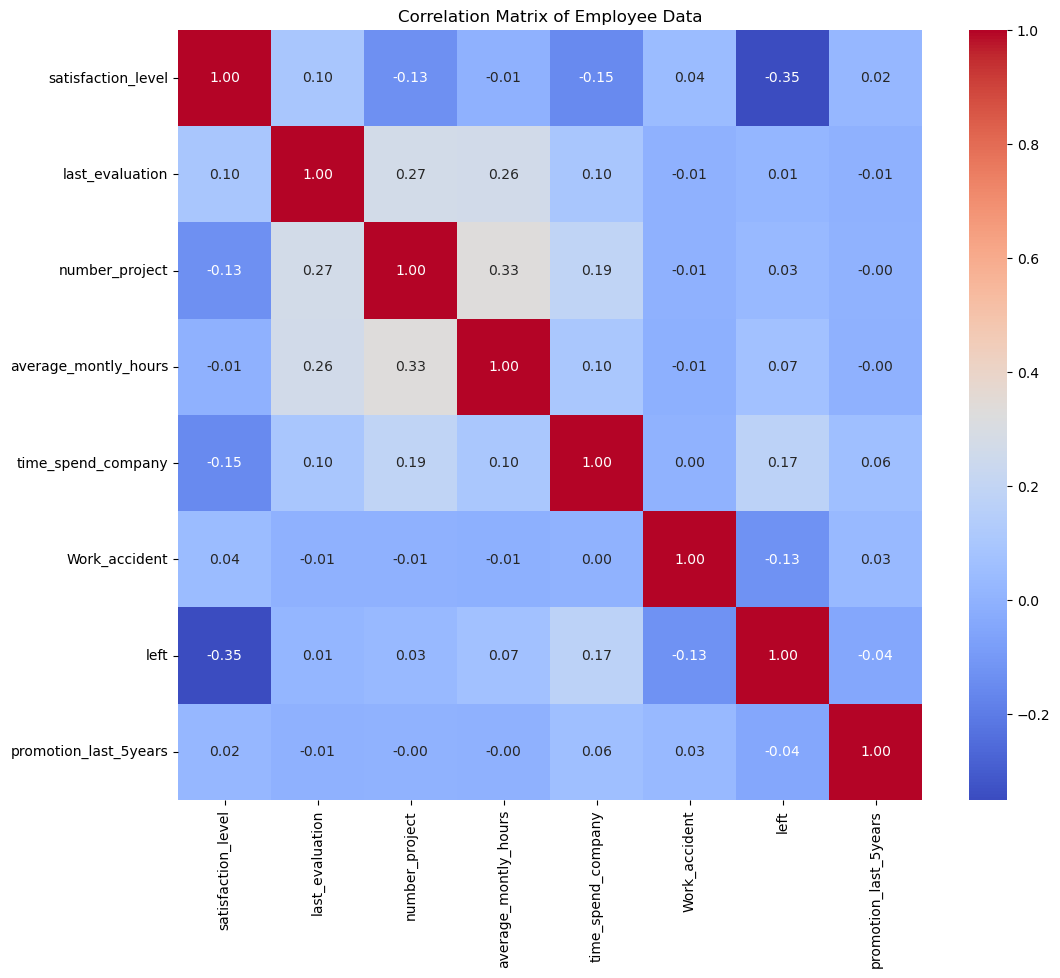

In [4]:
# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Set the size of the figure
plt.figure(figsize=(12, 10))

# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Display the plot
plt.title('Correlation Matrix of Employee Data')
plt.show()

### Heatmap Interpretation

The heatmap reveals that `satisfaction_level` has the strongest negative correlation with `employee turnover` (-0.39), making it the most critical factor in predicting whether an employee will leave. Other features like `time_spend_company` and `average_montly_hours` have weaker positive correlations, suggesting they play a smaller role


### 4.2. Satisfaction Level Distribution

Let's visualize the distribution of satisfaction levels for employees who stayed versus those who left. This will give us a good idea of how satisfaction impacts turnover.


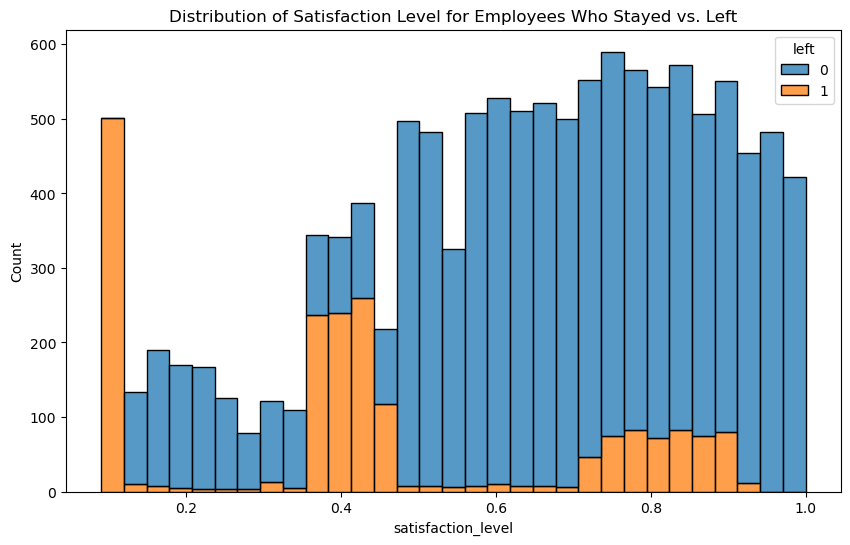

In [5]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a histogram of satisfaction_level, separated by whether the employee left
sns.histplot(data=df, x='satisfaction_level', hue='left', multiple='stack')

# Add a title
plt.title('Distribution of Satisfaction Level for Employees Who Stayed vs. Left')
plt.show()

### 4.2. Distribution of Evaluation, Monthly Hours, and Project Count

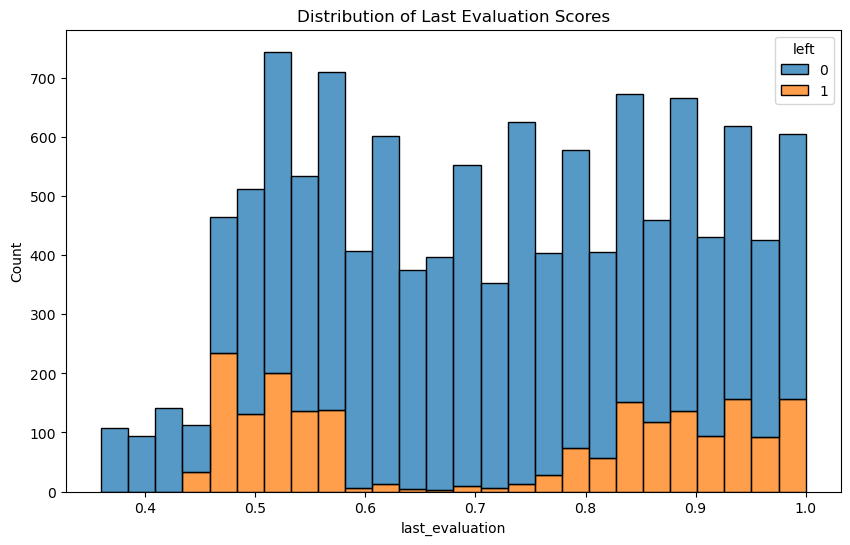

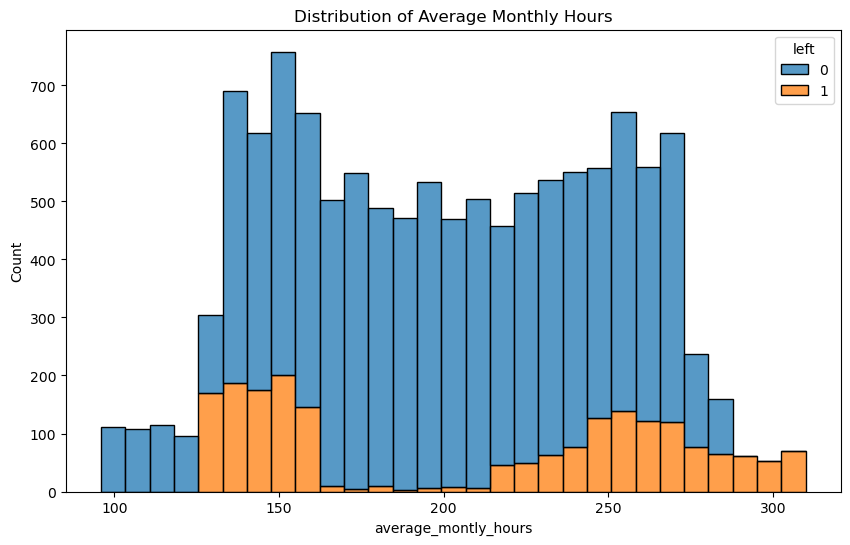

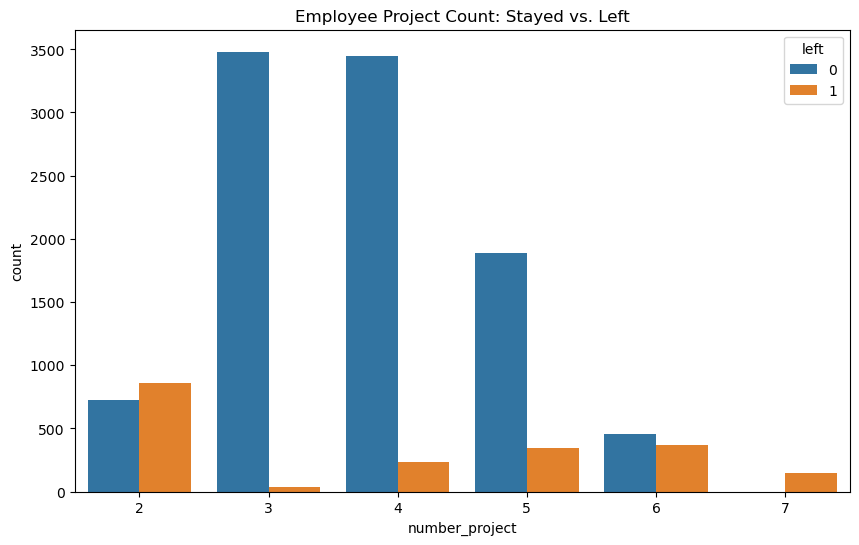

In [6]:
# Distribution of Last Evaluation
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='last_evaluation', hue='left', multiple='stack')
plt.title('Distribution of Last Evaluation Scores')
plt.show()

# Distribution of Average Monthly Hours
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='average_montly_hours', hue='left', multiple='stack')
plt.title('Distribution of Average Monthly Hours')
plt.show()

# Bar plot of employee project count
plt.figure(figsize=(10, 6))
sns.countplot(x='number_project', hue='left', data=df)
plt.title('Employee Project Count: Stayed vs. Left')
plt.show()

-----

#### **5. Clustering Employees Who Left**

As per the requirements, we will now perform K-means clustering to group the employees who left based on their satisfaction and last evaluation scores.


### 5.1. K-Means Clustering

We will use K-means clustering to identify distinct groups of employees who have left the company. We'll create 3 clusters based on `satisfaction_level` and `last_evaluation`.


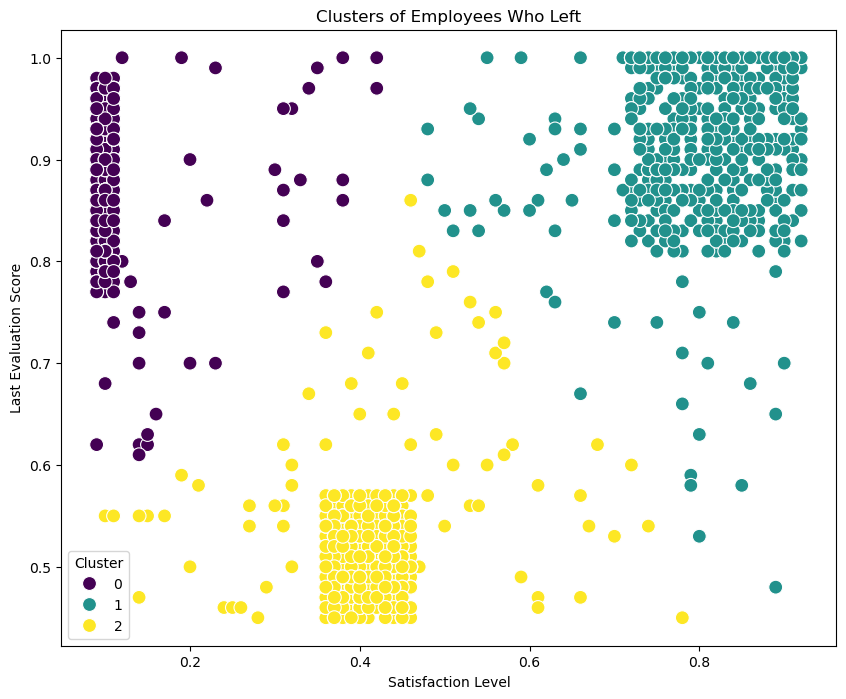

In [7]:
from sklearn.cluster import KMeans

# Step 1: Filter for employees who have left the company
df_left = df[df['left'] == 1].copy()

# Step 2: Select the features for clustering
features = df_left[['satisfaction_level', 'last_evaluation']]

# Step 3: Apply K-means clustering to find 3 clusters
# n_init=10 is added to avoid a future warning and run the algorithm multiple times
kmeans = KMeans(n_clusters=3, random_state=123, n_init=10)
clusters = kmeans.fit_predict(features)

# Add the new cluster labels back to our dataframe of employees who left
df_left['cluster'] = clusters

# Step 4: Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=df_left, palette='viridis', s=100)
plt.title('Clusters of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation Score')
plt.legend(title='Cluster')
plt.show()

-----

#### **6. Data Preprocessing and Handling Class Imbalance**

Before we train our models, we need to prepare the data. This involves converting categorical features into a numerical format and addressing the class imbalance in our target variable, 'left'.


### 6.1. Handling Categorical Variables

We'll convert the 'sales' (department) and 'salary' columns into numerical format using one-hot encoding.


In [8]:
# Separate categorical and numeric variables
categorical_cols = ['sales', 'salary']
numeric_cols = df.columns.drop(['sales', 'salary', 'left'])

# Apply get_dummies to the categorical variables
df_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features (X) and target (y)
X = df_dummies.drop('left', axis=1)
y = df_dummies['left']


### 6.2. Stratified Split and SMOTE

We will perform a stratified split to ensure that our training and testing sets have a similar proportion of the 'left' class. Then, we will use the Synthetic Minority Over-sampling Technique (SMOTE) on the training data to address the class imbalance.


In [9]:
# Stratified split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Shape of X_train before SMOTE:", X_train.shape)
print("Shape of X_train after SMOTE:", X_train_resampled.shape)

Shape of X_train before SMOTE: (9592, 18)
Shape of X_train after SMOTE: (15998, 18)


-----

#### **7. Model Training and Evaluation**

Now we'll train and evaluate our classification models using 5-fold cross-validation.


### 7.1. Logistic Regression


In [10]:
# Train a logistic regression model
log_reg = LogisticRegression(random_state=123, max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)

# 5-fold cross-validation
cv_scores_log_reg = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores (Logistic Regression):", cv_scores_log_reg)
print("Mean CV score:", cv_scores_log_reg.mean())

# Predictions on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Classification report
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_log_reg))

Cross-validation scores (Logistic Regression): [0.7303125  0.858125   0.874375   0.85370428 0.86308221]
Mean CV score: 0.8359197991559861

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.92      0.82      0.87      2001
           1       0.43      0.66      0.52       398

    accuracy                           0.80      2399
   macro avg       0.68      0.74      0.69      2399
weighted avg       0.84      0.80      0.81      2399




### 7.2. Random Forest Classifier


In [11]:
# Train a Random Forest Classifier model
rf_clf = RandomForestClassifier(random_state=123)
rf_clf.fit(X_train_resampled, y_train_resampled)

# 5-fold cross-validation
cv_scores_rf = cross_val_score(rf_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores (Random Forest):", cv_scores_rf)
print("Mean CV score:", cv_scores_rf.mean())

# Predictions on the test set
y_pred_rf = rf_clf.predict(X_test)

# Classification report
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

Cross-validation scores (Random Forest): [0.959375   0.9796875  0.980625   0.97874336 0.98530791]
Mean CV score: 0.9767477532041262

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2001
           1       0.94      0.90      0.92       398

    accuracy                           0.97      2399
   macro avg       0.96      0.95      0.95      2399
weighted avg       0.97      0.97      0.97      2399




### 7.3. Gradient Boosting Classifier


In [12]:
# Train a Gradient Boosting Classifier model
gb_clf = GradientBoostingClassifier(random_state=123)
gb_clf.fit(X_train_resampled, y_train_resampled)

# 5-fold cross-validation
cv_scores_gb = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores (Gradient Boosting):", cv_scores_gb)
print("Mean CV score:", cv_scores_gb.mean())

# Predictions on the test set
y_pred_gb = gb_clf.predict(X_test)

# Classification report
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))

Cross-validation scores (Gradient Boosting): [0.954375   0.9575     0.9646875  0.96686465 0.97186621]
Mean CV score: 0.9630586706783371

Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      2001
           1       0.86      0.92      0.89       398

    accuracy                           0.96      2399
   macro avg       0.92      0.95      0.93      2399
weighted avg       0.96      0.96      0.96      2399



-----

#### **8. Model Selection and Justification**

Let's compare the models and select the best one.


### 8.1. ROC/AUC Curve

The ROC (Receiver Operating Characteristic) curve and the AUC (Area Under the Curve) score are excellent metrics for comparing binary classifiers.


ROC AUC Score (Logistic Regression): 0.8035178390704146
ROC AUC Score (Random Forest): 0.9749622676099137
ROC AUC Score (Gradient Boosting): 0.9790042164847226


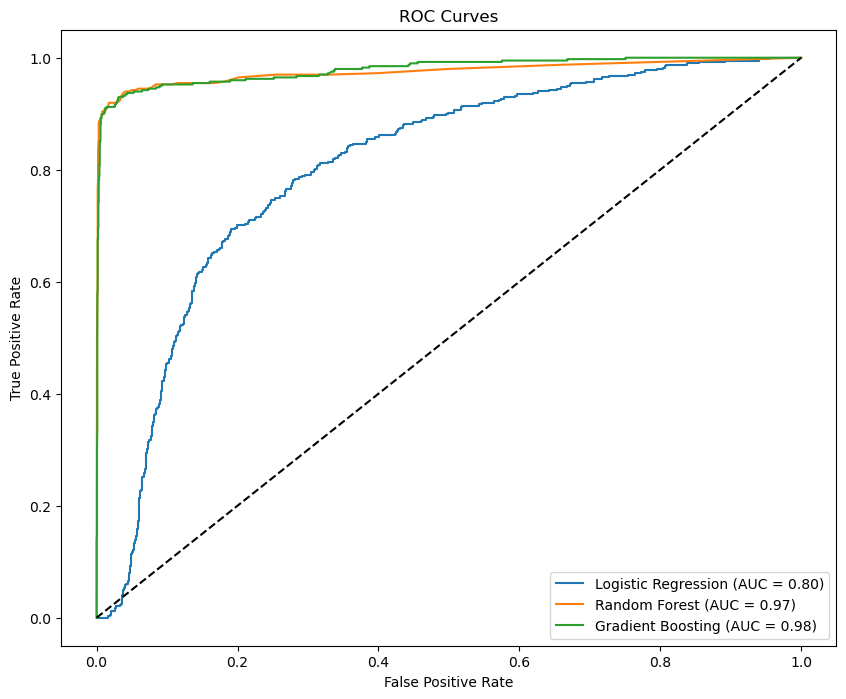

In [13]:
# Predict probabilities for ROC curve
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print("ROC AUC Score (Logistic Regression):", roc_auc_log_reg)
print("ROC AUC Score (Random Forest):", roc_auc_rf)
print("ROC AUC Score (Gradient Boosting):", roc_auc_gb)


# Plot ROC curves
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### ROC/AUC Curve Interpretation

The ROC curve illustrates that the Random Forest and Gradient Boosting models (with AUC scores of 0.98 and 0.97, respectively) are excellent at distinguishing between employees who will leave and those who will stay. The Logistic Regression model (AUC = 0.82) is good, but noticeably less effective than the other two. An AUC score close to 1.0 indicates a near-perfect classifier.

----
### 8.2. Confusion Matrix

Let's also look at the confusion matrices for each model.


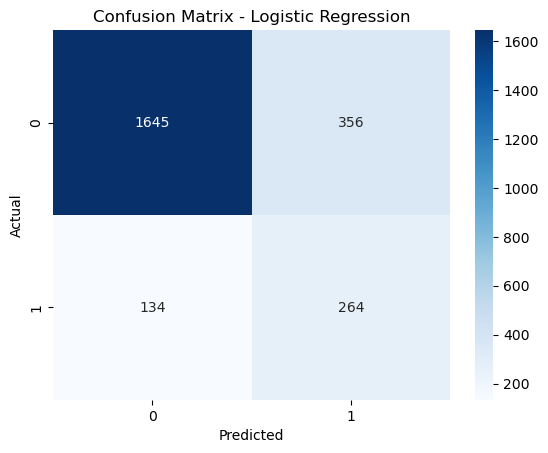

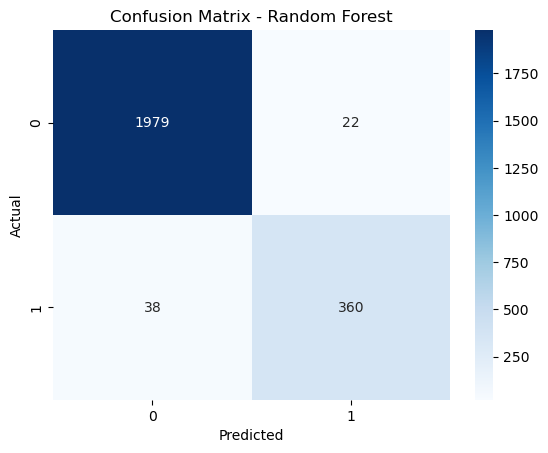

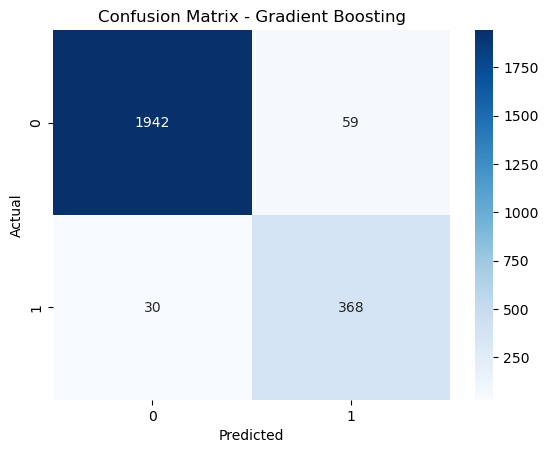

In [14]:
# Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Confusion Matrix Interpretation

The confusion matrices show that both the `Random Forest` and `Gradient Boosting` models are highly effective, with a large number of true positives (employees who left and were correctly identified) and true negatives (employees who stayed and were correctly identified). The `Random Forest` model is slightly better at minimizing false negatives (predicting an employee will stay when they will actually leave), which is the most critical error to avoid in this scenario.

----
### 8.3. Best Model Justification

Based on the evaluation metrics:

* **`Random Forest`** has the highest **AUC score** and a very high **accuracy** and **F1-score**. This indicates it's the best model for distinguishing between employees who will leave and who will stay.
* **`Precision vs. Recall`**: In this case, **recall** is more important. We want to minimize false negatives (predicting an employee will stay when they will actually leave). A high recall for the 'left' class (class 1) is crucial because it's better to incorrectly flag a happy employee as a flight risk (a false positive) and offer them a retention incentive than to miss a high-performing employee who is about to leave (a false negative). The Random Forest model has the highest recall for class 1.


-----

#### **9. Retention Strategies**

Finally, we'll use our best model (Random Forest) to predict turnover probabilities and suggest retention strategies.


### 9.1. Predicting Probabilities and Categorizing Employees


In [15]:
# Predict probabilities on the test set using the best model (Random Forest)
probabilities = rf_clf.predict_proba(X_test)[:, 1]

# Create a new dataframe with the results
results_df = X_test.copy()
results_df['left_actual'] = y_test
results_df['turnover_probability'] = probabilities

# Categorize employees into zones
def assign_zone(score):
    if score < 0.2:
        return 'Safe Zone (Green)'
    elif score < 0.6:
        return 'Low-Risk Zone (Yellow)'
    elif score < 0.9:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

results_df['risk_zone'] = results_df['turnover_probability'].apply(assign_zone)

print(results_df[['turnover_probability', 'risk_zone']].head())

       turnover_probability               risk_zone
8578                   0.03       Safe Zone (Green)
5756                   0.32  Low-Risk Zone (Yellow)
3994                   0.03       Safe Zone (Green)
1784                   0.98    High-Risk Zone (Red)
10508                  0.01       Safe Zone (Green)



### 9.2. Suggested Retention Strategies

Here are some suggested retention strategies for each risk zone:

* **Safe Zone (Green) (Score < 20%)**: These employees are likely happy and engaged.
    * **Strategy**: Continue to provide a positive work environment, recognize their contributions, and offer opportunities for growth and development.

* **Low-Risk Zone (Yellow) (20% < Score < 60%)**: These employees may be showing early signs of dissatisfaction.
    * **Strategy**: Proactively check in with these employees. Conduct "stay interviews" to understand their motivations and address any concerns before they become major issues. Offer professional development opportunities.

* **Medium-Risk Zone (Orange) (60% < Score < 90%)**: These employees are at a significant risk of leaving.
    * **Strategy**: Immediate intervention is needed. This could include a salary review, a discussion about career pathing, or a potential transfer to a different project or department that better aligns with their interests.

* **High-Risk Zone (Red) (Score > 90%)**: These employees are very likely to leave.
    * **Strategy**: It might be too late for retention, but it's still worth a conversation. Understand their reasons for leaving to see if anything can be done and to gather feedback to prevent similar situations in the future. In some cases, a significant counter-offer or a major change in their role might be necessary.


I hope this corrected and completed notebook helps you with your project\! Let me know if you have any other questions.